In [268]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

In [269]:
# f to fetch data from bam

def genes_extractor(samfile,
                    genes_bam,
                    index_file = True,
                    border_shift = 10000):
    if not index_file:
        pysam.index(samfile)
    
    samfile = pysam.AlignmentFile(samfile, 'rb')
    genes_bam = pysam.AlignmentFile(genes_bam, 'wb', template=samfile)
    
    d = []
    
    for index, gene in fetch_df.iterrows():
        start = gene['start'] - border_shift
        stop = gene['stop'] + border_shift
        if start < 0:
            start = 0
        for read in samfile.fetch(gene['chr'], start, stop):
            genes_bam.write(read)
        for pileupcolumn in samfile.pileup(gene['chr'], start, stop):
            d.append(
                    {
                        'position': pileupcolumn.pos,
                        'read_count': pileupcolumn.n,
                        'chromosome': gene['chr'],
                        'gene': gene['gene']
                    }
                )
            
    df_out = pd.DataFrame(d)
    df_out.drop_duplicates(subset=['position'], inplace = True)
    
    genes_bam.close()
    samfile.close()
    
    return df_out

In [271]:
# f for bins creation (of a specidic length)

def binner(seq_length,
           along,
           bin_size = 5000):
    bins = np.concatenate([([i]*bin_size) for i in along], axis=0)[:seq_length]
    return bins

In [272]:
fetch_df = pd.read_csv('interesting_genes.bed', sep='\t', header=None, names=['chr', 'start', 'stop', 'gene'])

In [273]:
rolling_window = 10000

In [274]:
df_normal = genes_extractor('../WES-normal.bam', genes_bam='../genes.bam')
df_tumor = genes_extractor('../WES-tumor.bam', genes_bam='../genes_tumor.bam')

In [275]:
df_total = df_tumor.merge(df_normal, left_on='position', right_on='position',
          suffixes=('_tumor', '_normal'), how='outer')
df_total['depth_ratio'] = np.log2(df_total['read_count_tumor'] / df_total['read_count_normal'])
df_total['median_rolling_depth_ratio'] = df_total['depth_ratio'].rolling(rolling_window, min_periods=1, center=True).median(skipna=False) 

In [277]:
#binning

bin_size = 5000
bins = binner(df_total.shape[0], 
              along = range(ceil(df_total.shape[0] / bin_size)), 
              bin_size = bin_size)

df_total['bin'] = bins

df_group = df_total[['position', 'depth_ratio', 'bin']].groupby(['bin'])['depth_ratio'].median()
df_group = df_group.reset_index() 

median_binning_depth_ratio = binner(df_total.shape[0], 
              along = df_group['depth_ratio'], 
              bin_size = bin_size)

df_total['median_binning_depth_ratio'] = median_binning_depth_ratio

In [278]:
df_group = df_total[['position', 'median_rolling_depth_ratio', 'bin']].groupby(['bin'])['median_rolling_depth_ratio'].median()
df_group = df_group.reset_index() 

median_rolling_binning_depth_ratio = binner(df_total.shape[0], 
                                             along = df_group['median_rolling_depth_ratio'], 
                                             bin_size = bin_size)

df_total['median_rolling_binning_depth_ratio'] = median_rolling_binning_depth_ratio

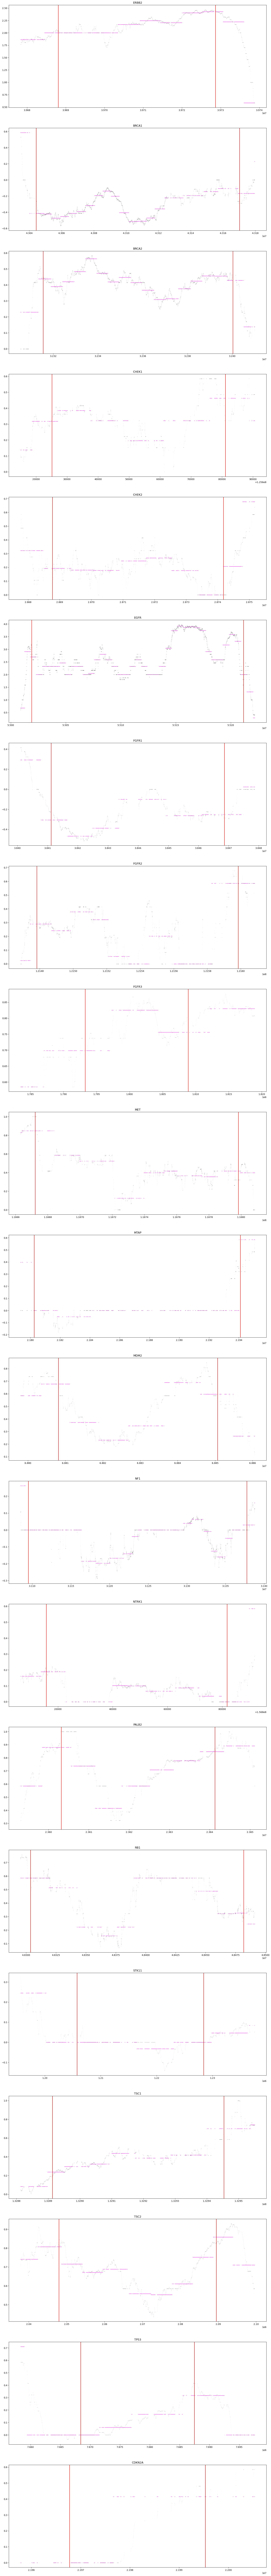

In [279]:
fig, axs = plt.subplots(len(fetch_df['gene']))
fig.set_size_inches(20, 200)

for i, gene in enumerate(fetch_df['gene']):
    target_gene = gene
    # median rolling depth ratio
    axs[i].scatter(df_total[df_total['gene_tumor'] == target_gene]['position'], df_total[df_total['gene_tumor'] == target_gene]['median_rolling_depth_ratio'], alpha=0.1, s=0.001, c='grey')
    # bins
    axs[i].scatter(df_total[df_total['gene_tumor'] == target_gene]['position'], df_total[df_total['gene_tumor'] == target_gene]['median_rolling_binning_depth_ratio'], alpha=0.5, s=0.001, c='violet')

    axs[i].axvline(x = fetch_df[fetch_df['gene'] == target_gene]['start'].iloc[0], color = 'r')
    axs[i].axvline(x = fetch_df[fetch_df['gene'] == target_gene]['stop'].iloc[0], color = 'r')
    axs[i].set_title(gene)

In [210]:
#df_total[df_total['Gene_tumor'] == target_gene].iloc[100:160]